# Multi-Channel CNN with 2 branches

In [1]:
import os
import matplotlib.pyplot as plt
import rasterio
import pandas as pd
import numpy as np
import geopandas as gpd
from shapely.geometry import Point
import sys
sys.path.append('..')
from Workflow import Workflow
from glob import glob


# Directories
os.makedirs("plots", exist_ok=True)
os.makedirs("models", exist_ok=True)


## Data pre-processing

In [2]:
# load the training,validation and test dataset from the workflow
wf = Workflow()
X_train,y_train, X_val, y_val, X_test, y_test = wf.load_data()

In [3]:
# # Extract the reprojected coordinates and store them

#train
geometry_train = [Point(xy) for xy in zip(X_train['lon'], X_train['lat'])]
Xtrain_gdf = gpd.GeoDataFrame(X_train, geometry=geometry_train, crs="EPSG:3577")  # WGS84 (lat/lon)

Xtrain_gdf['x'] = Xtrain_gdf.geometry.x
Xtrain_gdf['y'] = Xtrain_gdf.geometry.y

#validation
geometry_val = [Point(xy) for xy in zip(X_val['lon'], X_val['lat'])]
Xval_gdf = gpd.GeoDataFrame(X_val, geometry=geometry_val, crs="EPSG:3577")  # WGS84 (lat/lon)

Xval_gdf['x'] = Xval_gdf.geometry.x
Xval_gdf['y'] = Xval_gdf.geometry.y

#test
geometry_test = [Point(xy) for xy in zip(X_test['lon'], X_test['lat'])]
Xtest_gdf = gpd.GeoDataFrame(X_test, geometry=geometry_test, crs="EPSG:3577")  # WGS84 (lat/lon)

Xtest_gdf['x'] = Xtest_gdf.geometry.x
Xtest_gdf['y'] = Xtest_gdf.geometry.y

In [4]:
# 1. Load Raster Images
def load_data(filepath):
    with rasterio.open(filepath) as src:
        values = src.read(1)  # Load the first band
        transform = src.transform
    return values, transform

# 2. Extract Sample-Centered Terrain Images
def extract_sample_centered_images(clor_gdf, values, transform, size=32):
    rows, cols = values.shape
    half_size = size // 2
    terrain_images = []

    for _, row in clor_gdf.iterrows():
        x, y = row["x"], row["y"]
        col, row = ~transform * (x, y)
        col, row = int(col), int(row)

        if 0 <= row-half_size < rows and 0 <= col-half_size < cols:
            img = values[row-half_size:row+half_size, col-half_size:col+half_size]
            if img.shape == (size, size):
                terrain_images.append(img)
            else:
                terrain_images.append(np.zeros((size, size)))  # Pad with zeros if out of bounds
        else:
            terrain_images.append(np.zeros((size, size)))  # Completely out of bounds

    return np.array(terrain_images)

# 3. Load the recharge data

#the images that are going to be used are in this directory
directory_path = r"./aux_inputs"
# List all .tif files in the directory
tif_files = glob(os.path.join(directory_path, "*.tif"))

#empty list to store image values
columns_list = []

def centered_img(data):
    #routine for looping through all files and extracting centered images
    for file_path in tif_files:
        print(f"Processing file: {file_path}")

        # Load the data
        values, transform = load_data(file_path)

        # Extract the centered images
        imgs_ann = extract_sample_centered_images(data, values, transform)

        # Append the result to the list
        columns_list.append(imgs_ann)
    all_imgs_ann = list(zip(*columns_list))
    columns_list.clear()
    return all_imgs_ann 

# Use the updated coordinates
imgs_ann_train = centered_img(Xtrain_gdf)
imgs_ann_val = centered_img(Xval_gdf)
imgs_ann_test = centered_img(Xtest_gdf)

Processing file: ./aux_inputs\clay_raster_bound.tif
Processing file: ./aux_inputs\elevation_raster_bound.tif
Processing file: ./aux_inputs\ndvi_raster_bound.tif
Processing file: ./aux_inputs\PET_raster_bound.tif
Processing file: ./aux_inputs\rainfall_raster_bound.tif
Processing file: ./aux_inputs\clay_raster_bound.tif
Processing file: ./aux_inputs\elevation_raster_bound.tif
Processing file: ./aux_inputs\ndvi_raster_bound.tif
Processing file: ./aux_inputs\PET_raster_bound.tif
Processing file: ./aux_inputs\rainfall_raster_bound.tif
Processing file: ./aux_inputs\clay_raster_bound.tif
Processing file: ./aux_inputs\elevation_raster_bound.tif
Processing file: ./aux_inputs\ndvi_raster_bound.tif
Processing file: ./aux_inputs\PET_raster_bound.tif
Processing file: ./aux_inputs\rainfall_raster_bound.tif


#### Checking the centered images

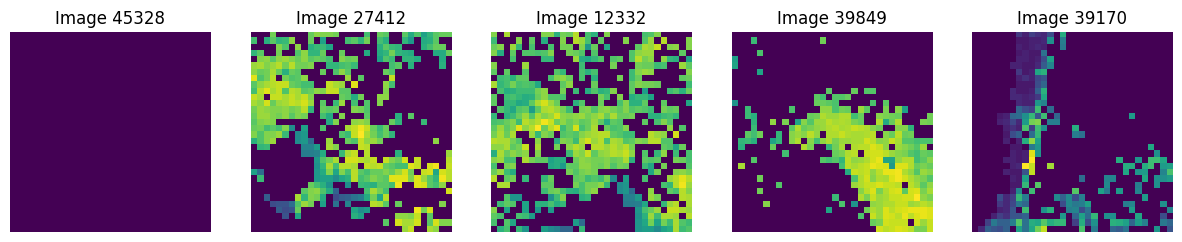

In [5]:
#how many centered images to show
n = 5

# Select random images or specific indices
indices = np.random.choice(len(imgs_ann_train), n, replace=False)

# Plot the images
fig, axs = plt.subplots(1, n, figsize=(15, 5))
for i, idx in enumerate(indices):
    axs[i].imshow(imgs_ann_train[idx][0], cmap="viridis")
    axs[i].set_title(f"Image {idx}")
    axs[i].axis("off")
plt.show()

### Normalizing the data

In [6]:
#normalizing the location input
def norm_loc_std(data):
    data.to_numpy()
    mean = (X_train.to_numpy()).mean(axis=0)
    std = (X_train.to_numpy()).std(axis=0)
    return ((data - mean)/std)

def norm_loc_min_max(data):
    data.to_numpy()
    max = (X_train.to_numpy()).max(axis=0)
    min = (X_train.to_numpy()).min(axis=0)
    return (data - max)/(max - min)


In [7]:
X_train = norm_loc_std(X_train)
X_val = norm_loc_std(X_val)
X_test = norm_loc_std(X_test)

In [8]:
#normalizing the auxiliary input
#normalizing the images
def norm_aux_mean_max(data):
    data = np.array(data)
    min = data.min(axis=(0, 2, 3), keepdims=True)
    max = data.max(axis=(0, 2, 3), keepdims=True)
    return ((data - min)/\
            (max - min))

def norm_aux_std(data):
    data = np.array(data)
    mean = data.mean(axis=(0, 2, 3), keepdims=True)
    std =  data.std(axis=(0,2,3), keepdims=True)
    return (data - mean)/std

In [9]:
imgs_ann_train = norm_aux_mean_max(imgs_ann_train)
imgs_ann_val = norm_aux_std(imgs_ann_val)
imgs_ann_test = norm_aux_std(imgs_ann_test)

## Model Definition

In [12]:
# Use neural network to learn relationship between terrain features and geochemistry ####
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.layers import Input, Conv2D, Activation, SpatialDropout2D, GlobalAveragePooling2D, Flatten, Dense, Dropout, Concatenate
from tensorflow.keras.initializers import HeNormal, Zeros
#from tensorflow_probability import distributions as tfd
#import tensorflow_probability as tfp

In [31]:
len(imgs_ann_train)

78854

In [48]:

# We assume that the number of features is the same in both branches
input_features = imgs_ann_train.shape[1]
loc_features = X_train.shape[1]
imagedim = imgs_ann_train.shape[2]


x_train = [np.transpose(imgs_ann_train, (0, 2, 3, 1)),X_train]
x_val = [np.transpose(imgs_ann_val, (0, 2, 3, 1)),X_val]
x_test = [np.transpose(imgs_ann_test, (0, 2, 3, 1)),X_test]
# Defining Model ----------------------------------------------------------
time = tf.timestamp()

dropratespat = 0.5  # match what model was trained with
dropratedense = 0.2  # match what model was trained with

kernel_ini = HeNormal()
bias_ini = Zeros()

# Convolutional stack:
conv_input = Input(shape=(imagedim, imagedim, input_features), name='conv_input')

conv_output = Conv2D(128, (3, 3), dilation_rate=1, strides=3, kernel_initializer=kernel_ini, bias_initializer=bias_ini)(conv_input)
conv_output = Activation("relu")(conv_output)
conv_output = SpatialDropout2D(rate=dropratespat)(conv_output)

conv_output = Conv2D(128, (3, 3), dilation_rate=1, strides=1, kernel_initializer=kernel_ini, bias_initializer=bias_ini)(conv_output)
conv_output = Activation("relu")(conv_output)
conv_output = SpatialDropout2D(rate=dropratespat)(conv_output)

conv_output = Conv2D(128, (3, 3), dilation_rate=1, strides=1, kernel_initializer=kernel_ini, bias_initializer=bias_ini)(conv_output)
conv_output = Activation("relu")(conv_output)
conv_output = SpatialDropout2D(rate=dropratespat)(conv_output)

conv_output = Conv2D(128, (3, 3), dilation_rate=1, strides=1, kernel_initializer=kernel_ini, bias_initializer=bias_ini)(conv_output)
conv_output = Activation("relu")(conv_output)
conv_output = SpatialDropout2D(rate=dropratespat)(conv_output)

conv_output = GlobalAveragePooling2D()(conv_output)
conv_output = Flatten()(conv_output)

# Auxiliary input:
auxiliary_input = Input(shape=(loc_features,), name='aux_input')

auxiliary_output = Dense(1920, kernel_initializer=kernel_ini, bias_initializer=bias_ini)(auxiliary_input)
auxiliary_output = Activation("relu")(auxiliary_output)
auxiliary_output = Dropout(rate=dropratedense)(auxiliary_output)
auxiliary_output = Flatten()(auxiliary_output)

# Main output:
main_output = Concatenate()([conv_output, auxiliary_output])
main_output = Dense(1024, kernel_initializer=kernel_ini, bias_initializer=bias_ini)(main_output)
main_output = Activation("relu")(main_output)
main_output = Dropout(rate=dropratedense)(main_output)
main_output = Dense(256, kernel_initializer=kernel_ini, bias_initializer=bias_ini)(main_output)
main_output = Activation("relu")(main_output)
main_output = Dropout(rate=dropratedense)(main_output)

main_output = Dense(units=1, activation="linear", name="output")(main_output) #singe value in the output

#main_output = Dense(units=2, activation="linear", name="dist_param", kernel_initializer=kernel_ini, bias_initializer=bias_ini)(main_output)
#main_output = tf.keras.layers.Lambda(          #multiple output values
#    lambda x: tf.concat([x[:, 0:1], tf.math.softplus(x[:, 1:2])], axis=1)
#)(main_output)

# Define model inputs
model = tf.keras.Model(
    inputs=[conv_input, auxiliary_input],
    outputs=main_output
)

# Define the negative log-likelihood function
def negloglik(y_true, y_pred):
    # Assuming y_pred is a distribution, e.g., Normal distribution
    dist = tfd.Normal(loc=y_pred[:, 0], scale=tf.math.softplus(y_pred[:, 1]))
    return -tf.reduce_mean(dist.log_prob(y_true))


# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), 
              loss='mean_squared_error')

# Summary of the model
model.summary()

Model: "functional_17"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
conv_input (InputLayer)         [(None, 32, 32, 5)]  0                                            
__________________________________________________________________________________________________
conv2d_32 (Conv2D)              (None, 10, 10, 128)  5888        conv_input[0][0]                 
__________________________________________________________________________________________________
activation_56 (Activation)      (None, 10, 10, 128)  0           conv2d_32[0][0]                  
__________________________________________________________________________________________________
spatial_dropout2d_32 (SpatialDr (None, 10, 10, 128)  0           activation_56[0][0]              
______________________________________________________________________________________

In [49]:
#class for saving the best weights
class SaveBestModel(tf.keras.callbacks.Callback):
    def __init__(self, save_best_metric='val_loss', this_max=False):
        self.save_best_metric = save_best_metric
        self.max = this_max
        if this_max:
            self.best = float('-inf')
        else:
            self.best = float('inf')

    def on_epoch_end(self, epoch, logs=None):
        metric_value = logs[self.save_best_metric]
        if self.max:
            if metric_value > self.best:
                self.best = metric_value
                self.best_weights = self.model.get_weights()

        else:
            if metric_value < self.best:
                self.best = metric_value
                self.best_weights= self.model.get_weights()

save_best_model = SaveBestModel()

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint

# Training ----------------------------------------------------------------
# Set batch size and number of epochs
batch_size = 10
epochs = 30

# Train the model with the specified parameters
history = model.fit(
    x_train, y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(x_val, y_val),
    shuffle=True,
    verbose=2,
    callbacks=[save_best_model]
    # Uncomment the following lines to use callbacks for early stopping and model checkpointing
    # callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=200),
    #            tf.keras.callbacks.ModelCheckpoint(monitor='val_loss', save_best_only=True, save_weights_only=True,
    #                                              filepath=os.path.join(os.getcwd(), "models/modelweights.hdf5"))]
)

# Find the minimum validation loss
min_val_loss = min(history.history['val_loss'])

# Note: Python does not have a direct equivalent of R's Sys.time() - time
# You would need to manually track the start and end time using datetime or time module

# Find the epoch with the minimum validation loss
best_epoch = history.history['val_loss'].index(min_val_loss)


Epoch 1/30
7886/7886 - 176s - loss: nan - val_loss: nan
Epoch 2/30
7886/7886 - 222s - loss: nan - val_loss: nan
Epoch 3/30
7886/7886 - 225s - loss: nan - val_loss: nan
Epoch 4/30
7886/7886 - 377s - loss: nan - val_loss: nan
Epoch 5/30
7886/7886 - 373s - loss: nan - val_loss: nan
Epoch 6/30


In [ ]:
# loading weights of best epoch
model.set_weights(save_best_model.best_weights)
# Create a DataFrame for holdout predictions and observations
holdout = pd.DataFrame({'obs': y_test, 'preds': model.predict(x_test)[:, 0]})

from sklearn.metrics import r2_score

# Calculate and print R squared and RMSE
print(f"R squared = {round(r2_score(holdout['obs'], holdout['preds']), 3)}")
print(f"RMSE = {round(np.sqrt(np.mean((holdout['preds'] - holdout['obs'])**2)), 3)}")

In [ ]:
bleepblop

# Nef: I have worked until here, the rest is the older code. The code I replaced the above code with is at the very end

# Old code

In [ ]:
# Training ----------------------------------------------------------------
# Set batch size and number of epochs
batch_size = 8
epochs = 1

# Train the model with the specified parameters
history = model.fit(
    x_train, y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(x_val, y_val),
    shuffle=True,
    verbose=2
    # Uncomment the following lines to use callbacks for early stopping and model checkpointing
    # callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=200),
    #            tf.keras.callbacks.ModelCheckpoint(monitor='val_loss', save_best_only=True, save_weights_only=True,
    #                                              filepath=os.path.join(os.getcwd(), "models/modelweights.hdf5"))]
)

# Find the minimum validation loss
min_val_loss = min(history.history['val_loss'])

# Note: Python does not have a direct equivalent of R's Sys.time() - time
# You would need to manually track the start and end time using datetime or time module

# Find the epoch with the minimum validation loss
best_epoch = history.history['val_loss'].index(min_val_loss)

# Save and load model weights
model.save_weights(os.path.join(os.getcwd(), "models/modelweights.weights.h5"))
model.load_weights(os.path.join(os.getcwd(), "models/modelweights.weights.h5"))

# Create a new model for predictions using the 'dist_param' layer
meanmodel = tf.keras.Model(
    inputs=model.input,
    outputs=model.get_layer("dist_param").output
)

# Save and load the mean model
meanmodel.save(os.path.join(os.getcwd(), "models/meanmodel.h5"))
meanmodel = tf.keras.models.load_model(os.path.join(os.getcwd(), "models/meanmodel.h5"))

# Create a DataFrame for holdout predictions and observations
holdout = pd.DataFrame({'obs': y_test, 'preds': meanmodel.predict(x_test)[:, 0]})

# Calculate and print R squared and RMSE
print(f"R squared = {round(np.corrcoef(holdout['preds'], holdout['obs'])[0, 1]**2, 3)}")
print(f"RMSE = {round(np.sqrt(np.mean((holdout['preds'] - holdout['obs'])**2)), 3)}")


In [6]:
# Define the model
model = models.Model(inputs=[i, auxiliary_input], outputs=main_output)

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), 
              loss='mean_squared_error',  # Adjust loss function as needed
              metrics=['accuracy'])

# Summary of the model
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 conv_input (InputLayer)        [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d_12 (Conv2D)             (None, 10, 10, 128)  3584        ['conv_input[0][0]']             
                                                                                                  
 activation_21 (Activation)     (None, 10, 10, 128)  0           ['conv2d_12[0][0]']              
                                                                                                  
 spatial_dropout2d_12 (SpatialD  (None, 10, 10, 128)  0          ['activation_21[0][0]']          
 ropout2D)                                                                                  

In [ ]:
bleepblop

## Modification of the original code to make it into a class

In [ ]:
# Use neural network to learn relationship between terrain features and geochemistry ####

import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, Activation, SpatialDropout2D, GlobalAveragePooling2D, Flatten, Dense, Dropout, Concatenate
from tensorflow.keras.initializers import HeNormal, Zeros
from tensorflow_probability import distributions as tfd

np.random.seed(321)
fold_size = gchem.shape[0] // 10
test = np.random.choice(gchem.shape[0], fold_size, replace=False)
val = np.random.choice(np.setdiff1d(np.arange(gchem.shape[0]), test), fold_size, replace=False)
train = np.setdiff1d(np.arange(gchem.shape[0]), np.concatenate((test, val)))

# Data Preparation --------------------------------------------------------

x_train = [imgs_ann[train, :, :], loc_ann[train, :]]
x_val = [imgs_ann[val, :, :], loc_ann[val, :]]
x_test = [imgs_ann[test, :, :], loc_ann[test, :]]

x_train[0] = x_train[0].reshape((x_train[0].shape[0], imagedim, imagedim, 1))
x_val[0] = x_val[0].reshape((x_val[0].shape[0], imagedim, imagedim, 1))
x_test[0] = x_test[0].reshape((x_test[0].shape[0], imagedim, imagedim, 1))

if logtrans:
    y_train = np.log(gchem[:, elem].astype(float))[train]
    y_val = np.log(gchem[:, elem].astype(float))[val]
    y_test = np.log(gchem[:, elem].astype(float))[test]
else:
    y_train = gchem[:, elem].astype(float)[train]
    y_val = gchem[:, elem].astype(float)[val]
    y_test = gchem[:, elem].astype(float)[test]

# Defining Model ----------------------------------------------------------
time = tf.timestamp()

dropratespat = 0.5  # match what model was trained with
dropratedense = 0.2  # match what model was trained with

kernel_ini = HeNormal()
bias_ini = Zeros()

# Convolutional stack:
conv_input = Input(shape=(imagedim, imagedim, 1), name='conv_input')

conv_output = Conv2D(128, (3, 3), dilation_rate=1, strides=3, kernel_initializer=kernel_ini, bias_initializer=bias_ini)(conv_input)
conv_output = Activation("relu")(conv_output)
conv_output = SpatialDropout2D(rate=dropratespat)(conv_output)

conv_output = Conv2D(128, (3, 3), dilation_rate=1, strides=1, kernel_initializer=kernel_ini, bias_initializer=bias_ini)(conv_output)
conv_output = Activation("relu")(conv_output)
conv_output = SpatialDropout2D(rate=dropratespat)(conv_output)

conv_output = Conv2D(128, (3, 3), dilation_rate=1, strides=1, kernel_initializer=kernel_ini, bias_initializer=bias_ini)(conv_output)
conv_output = Activation("relu")(conv_output)
conv_output = SpatialDropout2D(rate=dropratespat)(conv_output)

conv_output = Conv2D(128, (3, 3), dilation_rate=1, strides=1, kernel_initializer=kernel_ini, bias_initializer=bias_ini)(conv_output)
conv_output = Activation("relu")(conv_output)
conv_output = SpatialDropout2D(rate=dropratespat)(conv_output)

conv_output = GlobalAveragePooling2D()(conv_output)
conv_output = Flatten()(conv_output)

# Auxiliary input:
auxiliary_input = Input(shape=(3,), name='aux_input')

auxiliary_output = Dense(1920, kernel_initializer=kernel_ini, bias_initializer=bias_ini)(auxiliary_input)
auxiliary_output = Activation("relu")(auxiliary_output)
auxiliary_output = Dropout(rate=dropratedense)(auxiliary_output)
auxiliary_output = Flatten()(auxiliary_output)

# Main output:
main_output = Concatenate()([conv_output, auxiliary_output])
main_output = Dense(1024, kernel_initializer=kernel_ini, bias_initializer=bias_ini)(main_output)
main_output = Activation("relu")(main_output)
main_output = Dropout(rate=dropratedense)(main_output)
main_output = Dense(256, kernel_initializer=kernel_ini, bias_initializer=bias_ini)(main_output)
main_output = Activation("relu")(main_output)
main_output = Dropout(rate=dropratedense)(main_output)
main_output = Dense(units=2, activation="linear", name="dist_param", kernel_initializer=kernel_ini, bias_initializer=bias_ini)(main_output)
main_output = tf.keras.layers.Lambda(lambda x: tfd.Normal(loc=x[:, 0:1], scale=1e-3 + tf.nn.softplus(0.1 * x[:, 1:2])))(main_output)

# Remove the model if it exists (not needed in Python as we can just overwrite)
model = tf.keras.Model(
    inputs=[conv_input, auxiliary_input], 
    outputs=main_output
)

# Print the summary of the model
model.summary()

# Define the negative log-likelihood function
def negloglik(y, model):
    return -model.log_prob(y)

# Define the optimizer
opt = tf.keras.optimizers.Adam(learning_rate=0.001, decay=1e-6)

# Compile the model
model.compile(
    loss=negloglik,
    optimizer=opt
)

## Training

In [10]:
# Define the model
model = models.Model(inputs=[conv_input, auxiliary_input], outputs=main_output)

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), 
              loss='mean_squared_error',  # Adjust loss function as needed
              metrics=['accuracy'])

# Summary of the model
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 conv_input (InputLayer)        [(None, 32, 32, 1)]  0           []                               
                                                                                                  
 conv2d_24 (Conv2D)             (None, 10, 10, 128)  1280        ['conv_input[0][0]']             
                                                                                                  
 activation_42 (Activation)     (None, 10, 10, 128)  0           ['conv2d_24[0][0]']              
                                                                                                  
 spatial_dropout2d_24 (SpatialD  (None, 10, 10, 128)  0          ['activation_42[0][0]']          
 ropout2D)                                                                                  

In [41]:
if tf.config.list_physical_devices('GPU'):
    print("GPU is available")
else:
    print("GPU is not available")

GPU is not available


In [42]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print(tf.__version__)

Num GPUs Available:  0
2.18.0


In [49]:
# Training ----------------------------------------------------------------
# Set batch size and number of epochs
batch_size = 10
epochs = 1

# Train the model with the specified parameters
history = model.fit(
    x_train, y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(x_val, y_val),
    shuffle=True,
    verbose=2
    # Uncomment the following lines to use callbacks for early stopping and model checkpointing
    # callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=200),
    #            tf.keras.callbacks.ModelCheckpoint(monitor='val_loss', save_best_only=True, save_weights_only=True,
    #                                              filepath=os.path.join(os.getcwd(), "models/modelweights.hdf5"))]
)

# Find the minimum validation loss
min_val_loss = min(history.history['val_loss'])

# Note: Python does not have a direct equivalent of R's Sys.time() - time
# You would need to manually track the start and end time using datetime or time module

# Find the epoch with the minimum validation loss
best_epoch = history.history['val_loss'].index(min_val_loss)

# Save and load model weights
model.save_weights(os.path.join(os.getcwd(), "models/modelweights.weights.h5"))
model.load_weights(os.path.join(os.getcwd(), "models/modelweights.weights.h5"))

# Create a new model for predictions using the 'dist_param' layer
meanmodel = tf.keras.Model(
    inputs=model.input,
    outputs=model.get_layer("dist_param").output
)

# Save and load the mean model
meanmodel.save(os.path.join(os.getcwd(), "models/meanmodel.h5"))
meanmodel = tf.keras.models.load_model(os.path.join(os.getcwd(), "models/meanmodel.h5"))

# Create a DataFrame for holdout predictions and observations
holdout = pd.DataFrame({'obs': y_test, 'preds': meanmodel.predict(x_test)[:, 0]})

# Calculate and print R squared and RMSE
print(f"R squared = {round(np.corrcoef(holdout['preds'], holdout['obs'])[0, 1]**2, 3)}")
print(f"RMSE = {round(np.sqrt(np.mean((holdout['preds'] - holdout['obs'])**2)), 3)}")


7886/7886 - 102s - 13ms/step - accuracy: 0.0000e+00 - loss: 3019.5205 - val_accuracy: 0.0000e+00 - val_loss: 3567.0056


308/308 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step
R squared = 0.71
RMSE = 56.46


In [50]:
# Calculate and print R² score using numpy's corrcoef
try:
	r2_score = np.corrcoef(holdout['preds'], holdout['obs'])[0, 1]**2
	print(f"R² Score: {r2_score:.3f}")
except Exception as e:
	print(f"Error calculating R² score: {e}")

R² Score: 0.710


: 

In [20]:
if tf.config.list_physical_devices('GPU'):
    print("GPU is available")
else:
    print("GPU is not available")

GPU is not available


In [14]:

# Plot observed vs predicted values
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 8))
sns.scatterplot(x='obs', y='preds', data=holdout, alpha=0.1)
plt.plot([holdout['obs'].min(), holdout['obs'].max()], [holdout['obs'].min(), holdout['obs'].max()], 'k--')
plt.xlabel(f"Observed log({elem})" if logtrans else f"observed {elem}")
plt.ylabel(f"Predicted log({elem})" if logtrans else f"predicted {elem}")
plt.title(f"R² = {round(np.corrcoef(holdout['preds'], holdout['obs'])[0, 1]**2, 2)}     RMSE = {round(np.sqrt(np.mean((holdout['preds'] - holdout['obs'])**2)), 2)}")
plt.gca().set_aspect('equal', adjustable='box')
plt.savefig(f"plots/{elem}_mean_holdout_{round(np.corrcoef(holdout['preds'], holdout['obs'])[0, 1]**2, 2)*100}.png", dpi=300)

# Prepare training history data for plotting
trainhist = pd.DataFrame(history.history)[['loss', 'val_loss']]
trainhist.columns = ['training', 'testing']
trainhist['epoch'] = range(1, len(trainhist) + 1)

# Melt the training history data for plotting
trainhist_melted = trainhist.melt(id_vars='epoch', var_name='dataset', value_name='NLL')

# Plot training and validation loss over epochs
plt.figure(figsize=(10, 5))
sns.lineplot(x='epoch', y='NLL', hue='dataset', data=trainhist_melted)
plt.ylim(0, trainhist['testing'].quantile(0.999))
plt.savefig(f"plots/{elem}_training_{round(np.corrcoef(holdout['preds'], holdout['obs'])[0, 1]**2, 2)*100}.png", dpi=300)


ValueError: numpy.dtype size changed, may indicate binary incompatibility. Expected 96 from C header, got 88 from PyObject

Older code

In [ ]:
# 1. Load Raster Images
def load_rain_data(filepath):
    with rasterio.open(filepath) as src:
        rain = src.read(1)  # Load the first band
        transform = src.transform
    return rain, transform

# Dynamic path construction using os.path
img_variable = "rainfall_raster_bound.tif"
data_path = os.path.join("..", "CNN_from_R", "images_for_CNN", img_variable)
rain, transform = load_rain_data(data_path)

# 2. Load the recharge rate data
clor = pd.read_csv("../Data/dat07_u.csv")
quant = "Recharge RC 50% mm/y" 

# Drop NaNs for essential columns
clor = clor.dropna(subset=["lat", "lon", quant])

# Convert clor to a GeoDataFrame
geometry = [Point(xy) for xy in zip(clor['lon'], clor['lat'])]
clor_gdf = gpd.GeoDataFrame(clor, geometry=geometry, crs="EPSG:3577")  # WGS84 (lat/lon)

# Extract the reprojected coordinates
clor_gdf['x'] = clor_gdf.geometry.x
clor_gdf['y'] = clor_gdf.geometry.y


# 3. Extract Sample-Centered Terrain Images
def extract_sample_centered_images(clor_gdf, rain, transform, size=32):
    rows, cols = rain.shape
    half_size = size // 2
    terrain_images = []

    for _, row in clor_gdf.iterrows():
        x, y = row["x"], row["y"]
        col, row = ~transform * (x, y)
        col, row = int(col), int(row)
        
        if 0 <= row-half_size < rows and 0 <= col-half_size < cols:
            img = rain[row-half_size:row+half_size, col-half_size:col+half_size]
            if img.shape == (size, size):
                terrain_images.append(img)
            else:
                terrain_images.append(np.zeros((size, size)))  # Pad with zeros if out of bounds
        else:
            terrain_images.append(np.zeros((size, size)))  # Completely out of bounds

    return np.array(terrain_images)

# Use the updated coordinates
imgs_ann = extract_sample_centered_images(clor_gdf, rain, transform)

In [ ]:
with rasterio.open(data_paths) as src:
    transform = src.transform
    pixel_width = transform[0]   # `a` value: pixel size in x-direction
    pixel_height = -transform[4] # `e` value (negated because it's typically negative)
    print(f"Pixel size: {pixel_width} x {pixel_height}")

In [ ]:
np.random.seed(321)
fold_size = recharge_data.shape[0] // 10
test = np.random.choice(recharge_data.shape[0], fold_size, replace=False)
val = np.random.choice(np.setdiff1d(np.arange(recharge_data.shape[0]), test), fold_size, replace=False)
train = np.setdiff1d(np.arange(recharge_data.shape[0]), np.concatenate((test, val)))

# Data Preparation --------------------------------------------------------

x_train = [imgs_ann[train], loc_ann[train]]
x_val = [imgs_ann[val], loc_ann[val]]
x_test = [imgs_ann[test], loc_ann[test]]

x_train[0] = x_train[0].reshape((x_train[0].shape[0], 32, 32, 1))
x_val[0] = x_val[0].reshape((x_val[0].shape[0], 32, 32, 1))
x_test[0] = x_test[0].reshape((x_test[0].shape[0], 32, 32, 1))


y_train = recharge_data['Recharge RC 50% mm/y'].astype(float)[train]
y_val = recharge_data['Recharge RC 50% mm/y'].astype(float)[val]
y_test = recharge_data['Recharge RC 50% mm/y'].astype(float)[test]